In [185]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt
import seaborn as sns

### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [186]:
df = pd.read_csv('data.csv')
df.head(3)

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [188]:
print(df["conversion"].value_counts())
print('---')
print(df["offer"].value_counts())

0    54606
1     9394
Name: conversion, dtype: int64
---
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [189]:
df = df.rename(columns={"conversion": "target", "offer": "treatment"})
df['treatment'] = df.treatment.apply(lambda x: 
                                     0 if x == 'No Offer' 
                                     else 1 if x == 'Discount' 
                                     else 1 if  x == 'Buy One Get One' 
                                     else x)
print(df["treatment"].value_counts())

1    42694
0    21306
Name: treatment, dtype: int64


In [190]:
df.describe()

recency       history  used_discount     used_bogo   is_referral  \
count  64000.000000  64000.000000   64000.000000  64000.000000  64000.000000   
mean       5.763734    242.085656       0.551031      0.549719      0.502250   
std        3.507592    256.158608       0.497393      0.497526      0.499999   
min        1.000000     29.990000       0.000000      0.000000      0.000000   
25%        2.000000     64.660000       0.000000      0.000000      0.000000   
50%        6.000000    158.110000       1.000000      1.000000      1.000000   
75%        9.000000    325.657500       1.000000      1.000000      1.000000   
max       12.000000   3345.930000       1.000000      1.000000      1.000000   

          treatment        target  
count  64000.000000  64000.000000  
mean       0.667094      0.146781  
std        0.471257      0.353890  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      0.000000  
max        1.000000      1.000000

### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [191]:
df_X = pd.get_dummies(df)
df_X.drop('target', axis=1, inplace=True)
df_y = df['target']

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3)

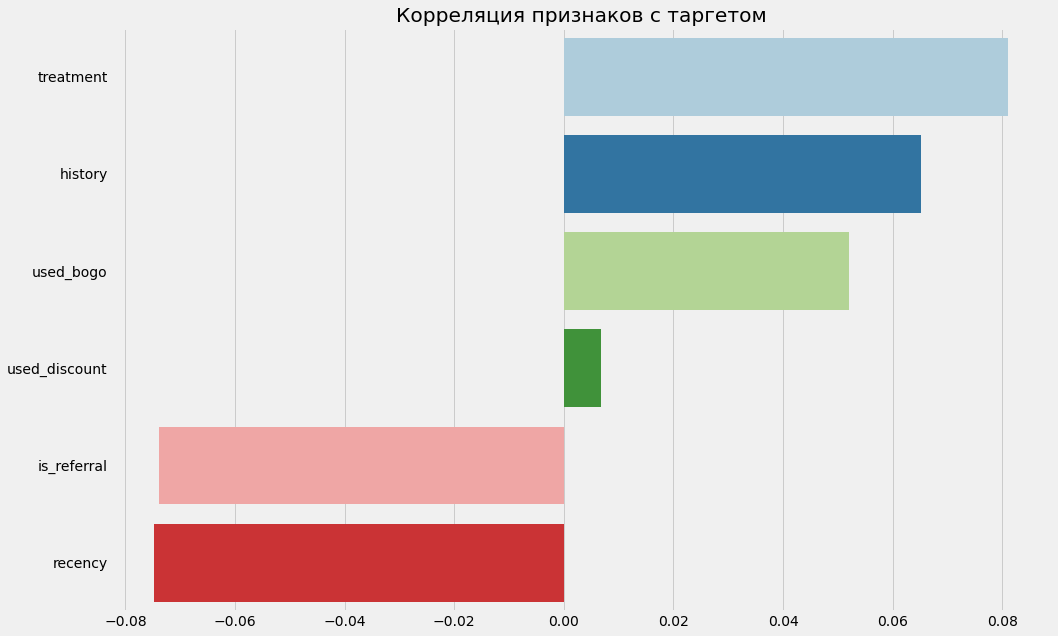

In [192]:
target_name = 'target'
corr_with_target = df.corr()[target_name].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 10))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция признаков с таргетом')
plt.show()

### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [193]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44800 entries, 47918 to 46483
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               44800 non-null  int64  
 1   history               44800 non-null  float64
 2   used_discount         44800 non-null  int64  
 3   used_bogo             44800 non-null  int64  
 4   is_referral           44800 non-null  int64  
 5   treatment             44800 non-null  int64  
 6   zip_code_Rural        44800 non-null  uint8  
 7   zip_code_Surburban    44800 non-null  uint8  
 8   zip_code_Urban        44800 non-null  uint8  
 9   channel_Multichannel  44800 non-null  uint8  
 10  channel_Phone         44800 non-null  uint8  
 11  channel_Web           44800 non-null  uint8  
dtypes: float64(1), int64(5), uint8(6)
memory usage: 2.6 MB


In [194]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [195]:
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@30%': []
}
treat_train = X_train['treatment']
treat_test = X_test['treatment']

cat_features = cat_cols

#### 1.1 Одна модель с признаком коммуникации

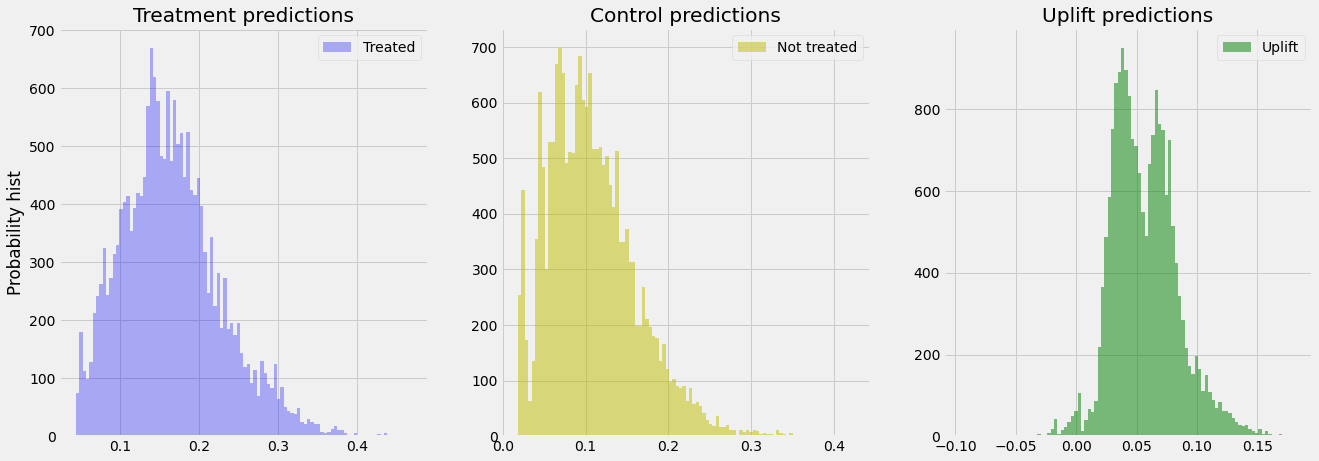

In [196]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### 1.2 Трансформация классов

In [197]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


#### 2.1 Две независимые модели

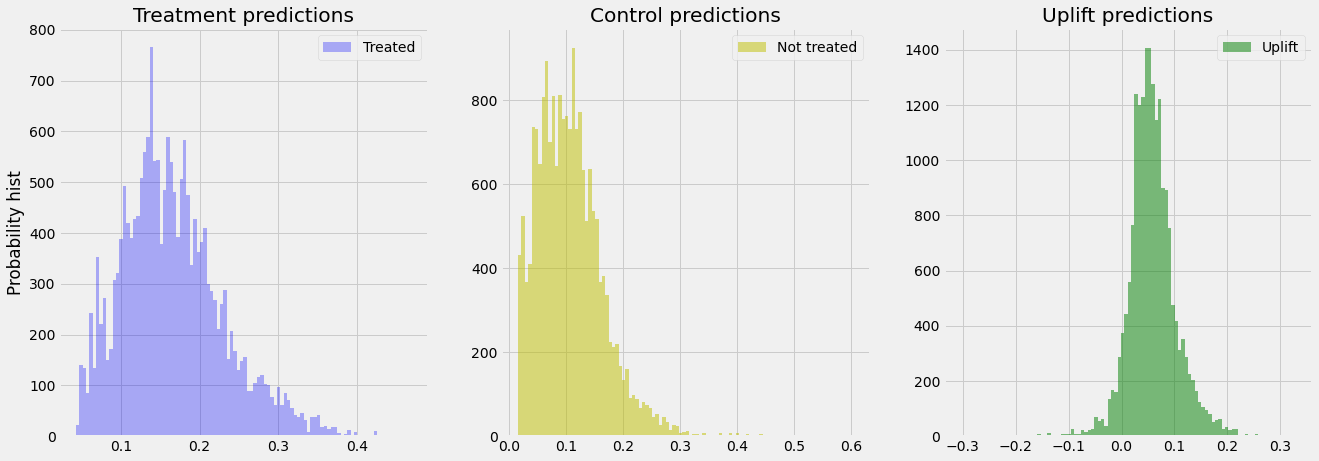

In [198]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [199]:
df = pd.DataFrame(data=models_results)
df

approach  uplift@20%  uplift@30%
0            SoloModel    0.072923    0.075344
1  ClassTransformation    0.225529    0.196092
2            TwoModels    0.077251    0.071719

### 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

#### Вариант с деревом решений

In [200]:
X_train_tree = X_train

features = [col for col in X_train_tree]

In [201]:
# !git clone https://github.com/uber/causalml
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

In [202]:
# !pip install graphviz

CPU times: user 4.48 s, sys: 5.05 ms, total: 4.49 s
Wall time: 5.77 s


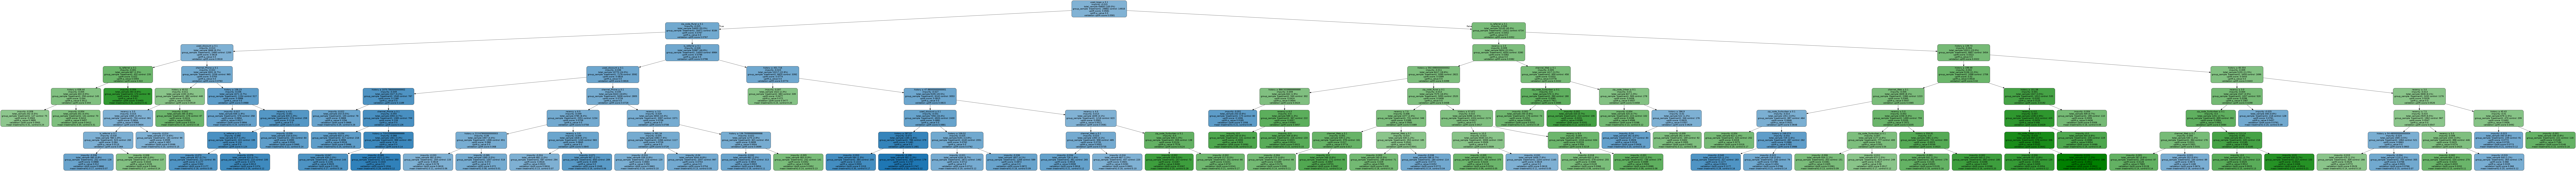

In [203]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Признак used_bogo стоит во главе деревеа, при значении равном или превышающем 0,1 идем в левую ветку дерева, следующими листьями дерева являются условия при призанках recency is_referral....	         